In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Statistical Model

In [10]:
torch.set_default_device("cpu")

In [11]:
words = ''.join(open("./names.txt", "r").read()).split('\n')

In [12]:
chars = sorted(list(set("".join(words))))

In [13]:
len(chars)

26

In [14]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = "."

In [15]:
N = torch.zeros((27, 27)).int()
for word in words:
    s = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(s, s[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        N[idx1, idx2] += 1

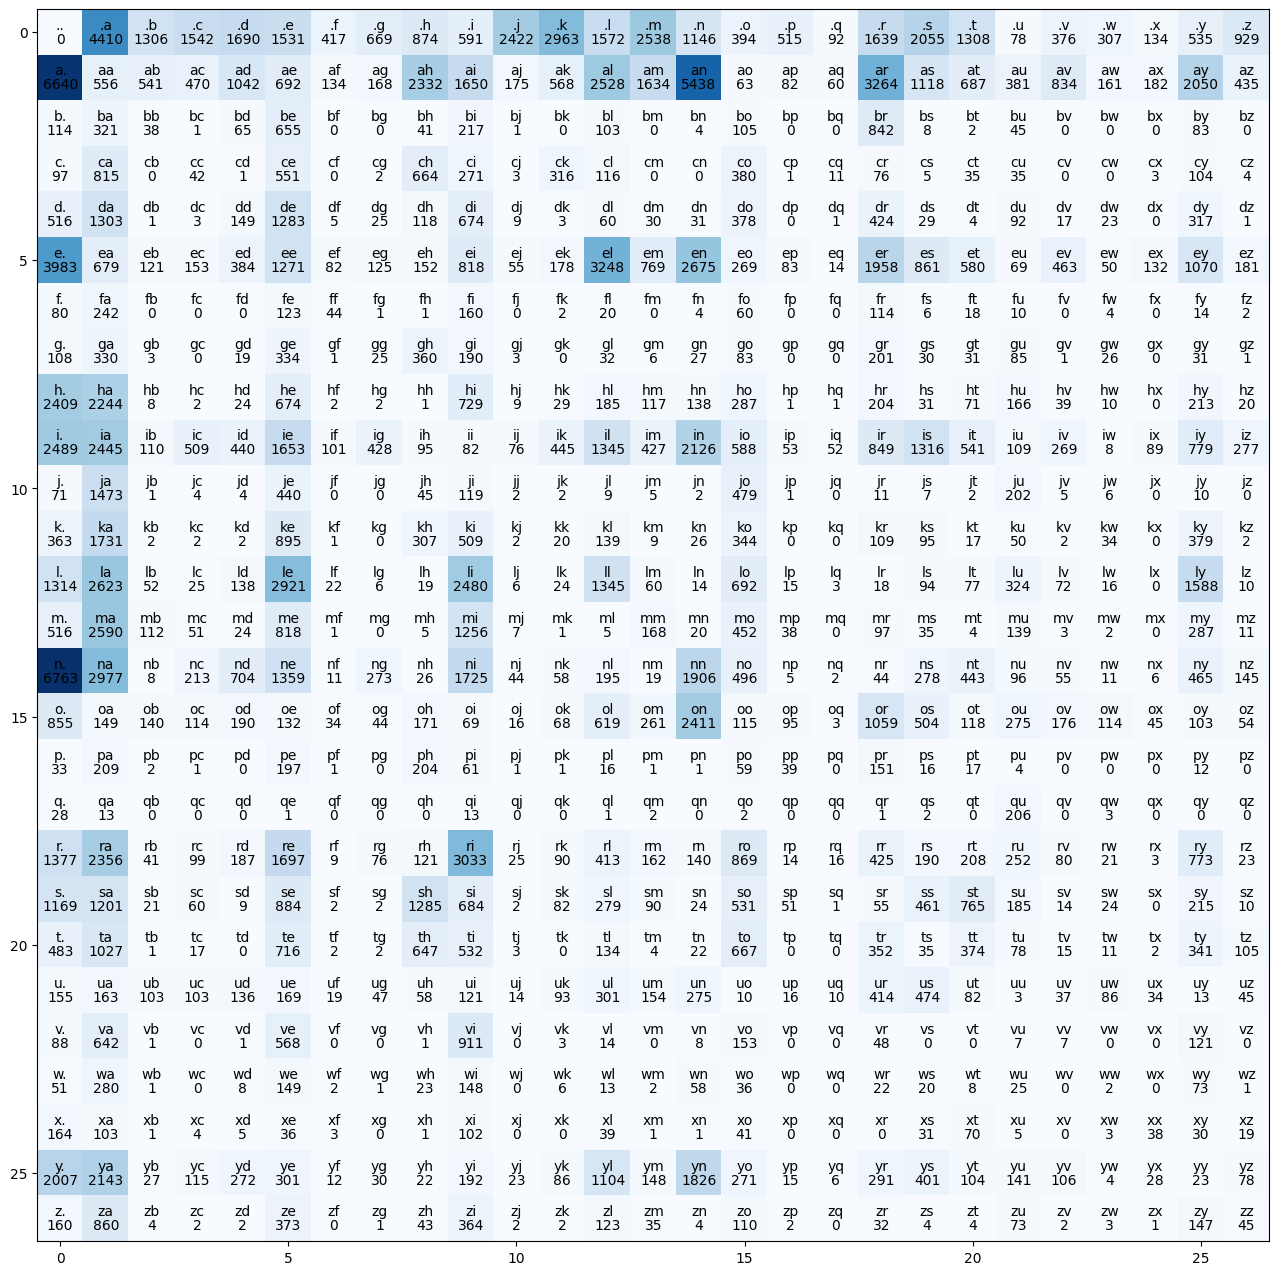

In [16]:
fig, ax = plt.subplots(1, figsize=(16,16))
ax.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        ax.text(j, i, chstr, ha="center", va="bottom")
        ax.text(j, i, N[i, j].item(), ha="center", va="top")

In [17]:
P = (N+1).float() # Model smoothing so that we don't get 0 probabilities for any bigram
P /= P.sum(1, keepdim=True)

#### Sampling

In [24]:
for i in range(5):
    idx = 0
    out = []
    while True:
        idx = torch.multinomial(P[idx], 1, replacement=True).item()
        ch = itos[idx]
        if ch == '.':
            break
        out.append(ch)
    print("".join(out))

hiyellalyn
elinn
rory
yn
kh


#### Evaluating our Statistical Model

In [347]:
# GOAL: Maximize likelihood of the data w.r.t model parameters (statistical modeling)
# Equivalent to maximizing the log likelihood (because log is monotonic)
# Equivalent to minimizing the negative log likelihood
# Equivalent to minimizing the average negative log likelihood
# log(a\*b\*c) = log(a) + log(b) + log(c)

n = 0
log_likelihood = 0
for word in words:
# for word in ["dean"]:
    s = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(s, s[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        prob = P[idx1, idx2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1
        # print(f"{ch1}{ch2}: {prob} {log_prob}")

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


## Neural Network

In [26]:
torch.set_default_device("cuda")

#### Compiling Dataset

In [228]:
xs, ys = [], []
for word in words:
    s = ["."] + list(word) + ["."]
    for ch1, ch2 in zip(s, s[1:]):
        idx1 = stoi[ch1]
        idx2 = stoi[ch2]
        xs.append(idx1)
        ys.append(idx2)

In [229]:
xs = torch.tensor(xs)

In [230]:
ys = torch.tensor(ys)

In [318]:
W = torch.randn((27, 27), requires_grad=True)

In [319]:
x_enc = F.one_hot(xs, 27).float()

#### Optimization Loop

In [320]:
for _ in range(100):
    # Forward Pass
    W.grad = None
    logits = x_enc@W

    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # loss = -(sum(probs[torch.arange(xs.shape[0]), ys].log())/xs.shape[0]) + 0.01*(W**2).mean().item() # Average Negative Log Likelihood

    loss = F.cross_entropy(logits, ys) + 0.01*(W**2).mean().item() # Same as above three lines

    # Backward pass
    loss.backward()
    W.data -= 40*W.grad

print(f"{loss=}")

loss=tensor(2.4962, device='cuda:0', grad_fn=<AddBackward0>)


#### Sampling

In [346]:
for i in range(5):
    ix = 0
    word = []
    while True:
        x_enc_pred = F.one_hot(torch.tensor(ix), 27).float()
        logits = x_enc_pred @ W
        counts = logits.exp()
        probs = counts / counts.sum()
        ix = torch.multinomial(probs, num_samples=1).item()
        if(ix==0):
            break
        word.append(itos[ix])
    print("".join(word))

sier
bichan
be
dy
benn
